In [16]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.sparse import csr_matrix

%matplotlib inline

In [17]:
class build_track:
    def __init__(self,F):
        num=200
        F1=F[0]
        F2=F[1]
        self.Center_X=np.linspace(-F1,1,num)
        self.Center_Y=np.linspace(0,0,num)
        
        self.WL=0.1
        self.WR=0.1
        
        self.Left_X=self.Center_X
        self.Left_Y=np.linspace(1,1,num)*self.WL
        
        self.Right_X=self.Center_X
        self.Right_Y=np.linspace(-1,-1,num)*self.WR
        

In [18]:
class build_path:
    def __init__(self,F,P,T):
        F1=F[0]
        F2=F[1]
        self.PX=np.array([-F1,0,F2,1])
        self.PY=P*T.WL
        self.S=np.array([0,F1,F1+F2,F1+1])
        self.WL=T.WL
        self.WR=T.WR
        self.track=T

        self.len=F1+1
        self.Vx=0.01
        self.Np=int(np.floor(self.len/self.Vx))+1
        self.Ns=2
        self.Nc=1
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        self.ind_Y=np.arange(Np)*Ns
        self.ind_Vy=1+np.arange(Np)*Ns
        self.ind_ay=Np*Ns+np.arange(Np-1)*Nc
        
        self.X=np.linspace(-F1,1,Np)

        # parameters of constraints
        self.Q=np.array([0,1])
        self.R=np.array([100.0])
        ind=np.floor(self.S/self.Vx)
        self.ind=np.array([int(i) for i in ind])

#          # ***********build sequential state space A_qp*x=b_qp******
        self.Ac=np.array([[0,1],[0,0] ])
        self.Bc=np.array([[0],[1]])
        self.Ad=np.eye(Ns)+self.Ac
        self.Bd=self.Bc

        # dynamics model      
        A_combined1=np.zeros(((Np-1)*Ns,Np*Ns))
        A_combined2=np.zeros(((Np-1)*Ns,(Np-1)*Nc))
        
        for index in range(Np-1):
            ind1=index*Ns+np.arange(Ns)
            ind2x=index*Ns+np.arange(Ns)
            ind2I=ind2x+Ns
            ind2u=index*Nc+np.arange(Nc)
            
            A_combined1[np.ix_(ind1,ind2I)]=np.eye(Ns)
            A_combined1[np.ix_(ind1,ind2x)]=-self.Ad
            A_combined2[np.ix_(ind1,ind2u)]=-self.Bd
            
        self.A_qp=np.hstack((A_combined1,A_combined2))
        self.b_qp=np.zeros(((Np-1)*Ns))
        
        # bnd
        Gx=csr_matrix((np.ones(Np),(np.arange(Np),self.ind_Y)),
                     shape=(Np,Np*Ns+(Np-1)*Nc)).toarray()
        self.G_qp=np.vstack((Gx,-Gx))

        hx=np.ones((Np,1))*self.WL
        self.h_qp=np.vstack((hx,hx))

        
        Q_w=np.tile(self.Q,(1,Np))
        R_w=np.tile(self.R,(1,Np-1))
        
        self.Q_qp=np.diag(np.hstack((Q_w,R_w))[0])
        self.P_qp=np.zeros((self.Q_qp.shape[0],1))
        
                             
    def generate(self):
        
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        num_PY=self.PY.shape[0]

       
        Ax=csr_matrix((np.ones(num_PY),(np.arange(num_PY),self.ind*Ns)),
                     shape=(num_PY,(Np)*Ns+(Np-1)*Nc)).toarray()
            
        bx=self.PY
        

        x=cp.Variable((Np*Ns+(Np-1)*Nc))
        cost=cp.quad_form(x,self.Q_qp)
                      
        constraints=[]
        constraints+=[self.A_qp@x==self.b_qp]
        constraints+=[Ax@x==self.PY]
        
        # initial & end angle ==0
        constraints+=[x[self.ind_Vy[0]]==0]
        constraints+=[x[self.ind_Vy[-1]]==0]
        
        # boundary
        constraints+=[x[self.ind_Y]>=-np.ones(Np)*self.WR,
                     x[self.ind_Y]<=np.ones(Np)*self.WL]
        
        prob=cp.Problem(cp.Minimize(cost),constraints)
        prob.solve()
        
     
        self.Y=x[self.ind_Y].value
        self.Vy=x[self.ind_Vy].value
        self.ay=x[self.ind_ay].value
        
        
    def plot(self):
        track=self.track
        path=self

        f=plt.figure()

        plt.plot(track.Center_X,track.Center_Y,'b--')
        plt.plot(track.Left_X,track.Left_Y,'b')
        plt.plot(track.Right_X,track.Right_Y,'b')
        plt.plot(path.X,path.Y,'k.')
        plt.plot(path.PX,path.PY,'ro')

        plt.axis('equal')

        np.max(np.abs(path.PY))

        f2=plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(path.Vy)

        plt.subplot(1,2,2)
        plt.plot(path.ay)


In [23]:
# F and P

class build_feature:
    
    def __init__(self):
        self.num_F=10
        self.num_P=20
        self.num_seg=3
        self.bnd=0.1
        self.total_num_F=self.num_F**(self.num_seg-1)
        self.total_num_P=self.num_P**(self.num_seg+1)
        
        # build F shape tuple
        self.size_F=()
        for i in range(self.num_seg-1):
            self.size_F+=(self.num_F,)
        
        # build P shape tuple
        self.size_P=()
        for i in range(self.num_seg+1):
            self.size_P+=(self.num_P,);

        # build F space
        self.space_F=np.linspace(0+self.bnd,1-self.bnd,self.num_F)
        
        # build P space
        self.space_P=np.linspace(-1,1,self.num_P)

    def fetch_feature_F(self,ind_F):
        
        sub_F = np.array(list(np.unravel_index(ind_F,self.size_F)))
        self.F = np.array([self.space_F[i] for i in sub_F])
        
    def fetch_feature_P(self,ind_P):
        
        sub_P = np.array(list(np.unravel_index(ind_P,self.size_P)))
        self.P = np.array([self.space_P[i] for i in sub_P])

In [25]:
feature=build_feature()

F_start = input('Input start index of F: ')
F_end = input('Input end index of F, max is {}:'.format(build_feature().total_num_F))
P_start = input('Input start index of P, default if {}: '.format(0))
P_end = input('Input end index of P, max and default is {}: '.format(build_feature().total_num_P))

F_start = int(F_start)
F_end = int(F_end)

P_start=0 if P_start=='' else int(P_start)
P_end=build_feature().total_num_P if P_end=='' else int(P_end)



for ind_F in range(F_start,F_end):
    feature.fetch_feature_F(ind_F)
    track=build_track(feature.F)
    print('Current F is ',ind_F)
    
    data = []
    
    for ind_P in tqdm(range(P_start,P_end)):
        feature.fetch_feature_P(ind_P)
        path=build_path(feature.F,feature.P,track)
        path.generate()
        
        data.append({'F':feature.F,'P':feature.P,'path':path.Y})
        
    name='F_{}_P_{}_to_{}.npy'.format(ind_F,P_start,P_end)
    path='/home/jovyan/work/sv_data/'
    np.save(path+name,data)
    
# path.plot()

Input start index of F: 0
Input end index of F, max is 100:1
Input start index of P, default if 0: 
Input end index of P, max and default is 160000: 


  0%|          | 1/160000 [00:00<5:46:50,  7.69it/s]

Current F is  0


  0%|          | 202/160000 [00:13<3:02:39, 14.58it/s]

Solver interrupted


ValueError: OSQP solve error!

In [22]:
feature.total_num_P

10000

0.10710954666137695


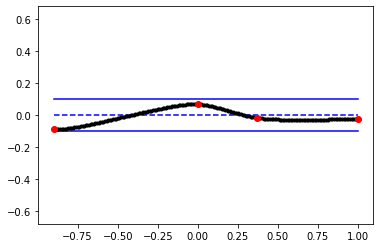

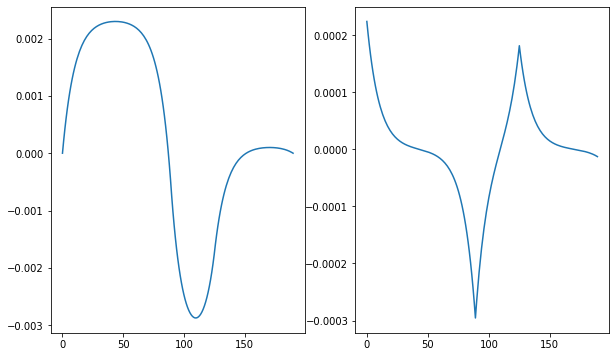

In [160]:
feature=build_feature()
ind_F=93
ind_P=14567
feature.fetch_feature_F(ind_F)
feature.fetch_feature_P(ind_P)

track=build_track(feature.F)
path=build_path(feature.F,feature.P,track)

times=1
start=time.time()
for i in range(times):
#     path.generate()
    path.generate()

end=time.time()

print((end-start))

path.plot()